<a href="https://colab.research.google.com/github/Apitoxinum/SF-cardiovascular-disease/blob/main/SF_DL_NN_Project_CVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import torch
import torch.nn as nn
import joblib

In [2]:
train_df = pd.read_csv("/train.csv")
test_df = pd.read_csv("/test.csv")

In [3]:
# Просмотр первых 5 строк обучающих данных
print("Первые 5 строк обучающих данных:")
display(train_df.head())

# Основная информация о данных (типы столбцов, количество ненулевых значений)
print("\nИнформация о обучающих данных:")
train_df.info()

# Проверка на пропущенные значения
print("\nПропущенные значения в обучающих данных:")
print(train_df.isnull().sum())

Первые 5 строк обучающих данных:


,ID,age,sex,chest,resting_blood_pressure,serum_cholestoral,fasting_blood_sugar,resting_electrocardiographic_results,maximum_heart_rate_achieved,exercise_induced_angina,oldpeak,slope,number_of_major_vessels,thal,class
0,0,49.207124,0,4.000000,162.996167,181.108682,0,0,148.227858,1,0.944547,2,0,3,1
1,1,53.628425,1,1.741596,130.233730,276.474630,0,2,152.917139,0,0.119070,2,0,3,0
2,2,49.591426,1,4.000000,146.999012,223.300517,1,2,102.352090,1,1.616747,2,2,7,1
3,3,58.991445,1,4.000000,112.369143,187.245501,0,0,158.164750,1,0.000000,1,1,7,1
4,4,51.053602,1,1.954609,138.032047,238.482868,0,0,172.540828,0,1.150464,1,1,3,0



Информация о обучающих данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600000 entries, 0 to 599999
Data columns (total 15 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    600000 non-null  int64  
 1   age                                   600000 non-null  float64
 2   sex                                   600000 non-null  int64  
 3   chest                                 600000 non-null  float64
 4   resting_blood_pressure                600000 non-null  float64
 5   serum_cholestoral                     600000 non-null  float64
 6   fasting_blood_sugar                   600000 non-null  int64  
 7   resting_electrocardiographic_results  600000 non-null  int64  
 8   maximum_heart_rate_achieved           600000 non-null  float64
 9   exercise_induced_angina               600000 non-null  int64  
 10  oldpeak                             

In [4]:
# Удалим ID - он не нужен для модели
train_df.drop('ID', axis=1, inplace=True)
test_df.drop('ID', axis=1, inplace=True)

Первые наблюдения:

* Данные уже в числовом формате, что удобно для работы.

* Пропущенных значений нет.

* Некоторые значения представлены как float (дробные числа), хотя должны быть целыми (например, возраст, количество сосудов).

* Нужно проверить диапазоны значений на соответствие описанию.

In [5]:
# Проверка уникальных значений в категориальных признаках
categorical_features = ['sex', 'fasting_blood_sugar',
                        'resting_electrocardiographic_results',
                        'exercise_induced_angina', 'slope',
                        'number_of_major_vessels', 'thal', 'class']

for feature in categorical_features:
    print(f"{feature}: {sorted(train_df[feature].unique())}")

sex: [np.int64(0), np.int64(1)]
fasting_blood_sugar: [np.int64(0), np.int64(1)]
resting_electrocardiographic_results: [np.int64(0), np.int64(1), np.int64(2)]
exercise_induced_angina: [np.int64(0), np.int64(1)]
slope: [np.int64(1), np.int64(2), np.int64(3)]
number_of_major_vessels: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
thal: [np.int64(3), np.int64(6), np.int64(7)]
class: [np.int64(0), np.int64(1)]


In [6]:
# Преобразуем целочисленные признаки
int_features = ['age', 'number_of_major_vessels', 'thal']
for feature in int_features:
    train_df[feature] = train_df[feature].astype(int)
    test_df[feature] = test_df[feature].astype(int)

# Проверим результат
print("\nТипы данных после преобразования:")
train_df[int_features].dtypes


Типы данных после преобразования:


,0
age,int64
number_of_major_vessels,int64
thal,int64


Распределение классов:
class
0    333489
1    266511
Name: count, dtype: int64


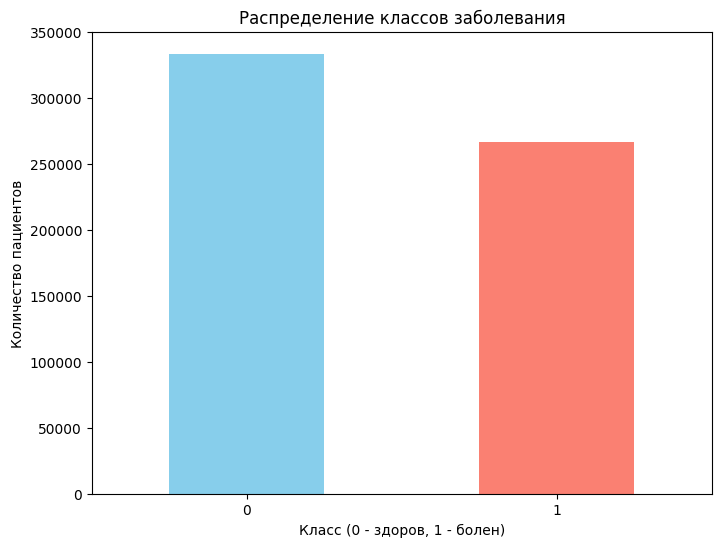

In [7]:
# Распределение классов
import matplotlib.pyplot as plt

class_distribution = train_df['class'].value_counts()
print("Распределение классов:")
print(class_distribution)

plt.figure(figsize=(8, 6))
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Распределение классов заболевания')
plt.xlabel('Класс (0 - здоров, 1 - болен)')
plt.ylabel('Количество пациентов')
plt.xticks(rotation=0)
plt.show()

In [8]:
# Основные статистики по числовым признакам
numeric_features = ['age', 'resting_blood_pressure', 'serum_cholestoral',
                    'maximum_heart_rate_achieved', 'oldpeak']

print("Основные статистики:")
train_df[numeric_features].describe()

Основные статистики:


,age,resting_blood_pressure,serum_cholestoral,maximum_heart_rate_achieved,oldpeak
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,53.926715,131.340485,249.592420,149.592069,1.051391
std,9.091247,17.842450,51.699976,23.072593,1.144288
min,26.000000,82.918527,98.326263,61.844168,-0.806788
25%,48.000000,119.924094,216.475964,135.704237,0.000000
50%,55.000000,129.727941,244.233699,153.224828,0.811101
75%,60.000000,139.915216,274.345453,165.165497,1.674081
max,79.000000,209.673650,527.755764,208.735196,6.803372


In [9]:
# Проверим уникальные значения chest до преобразования
print("Уникальные значения chest до преобразования:", train_df['chest'].unique())

Уникальные значения chest до преобразования: [4.       1.741596 1.954609 ... 1.680331 1.949117 1.295676]


In [10]:
# Преобразуем 'chest' в категориальный
train_df['chest'] = train_df['chest'].clip(1, 4).round().astype(int)
test_df['chest'] = test_df['chest'].clip(1, 4).round().astype(int)
print("Уникальные значения chest после преобразования:", train_df['chest'].unique())


Уникальные значения chest после преобразования: [4 2 3 1]


In [11]:
# one-hot encoding
categorical_features = ['chest', 'resting_electrocardiographic_results', 'slope', 'thal']
train_df = pd.get_dummies(train_df, columns=categorical_features, prefix=categorical_features)
test_df = pd.get_dummies(test_df, columns=categorical_features, prefix=categorical_features)

# Проверяем результат
print("\nКолонки после преобразования:")
print(train_df.columns.tolist())


Колонки после преобразования:
['age', 'sex', 'resting_blood_pressure', 'serum_cholestoral', 'fasting_blood_sugar', 'maximum_heart_rate_achieved', 'exercise_induced_angina', 'oldpeak', 'number_of_major_vessels', 'class', 'chest_1', 'chest_2', 'chest_3', 'chest_4', 'resting_electrocardiographic_results_0', 'resting_electrocardiographic_results_1', 'resting_electrocardiographic_results_2', 'slope_1', 'slope_2', 'slope_3', 'thal_3', 'thal_6', 'thal_7']


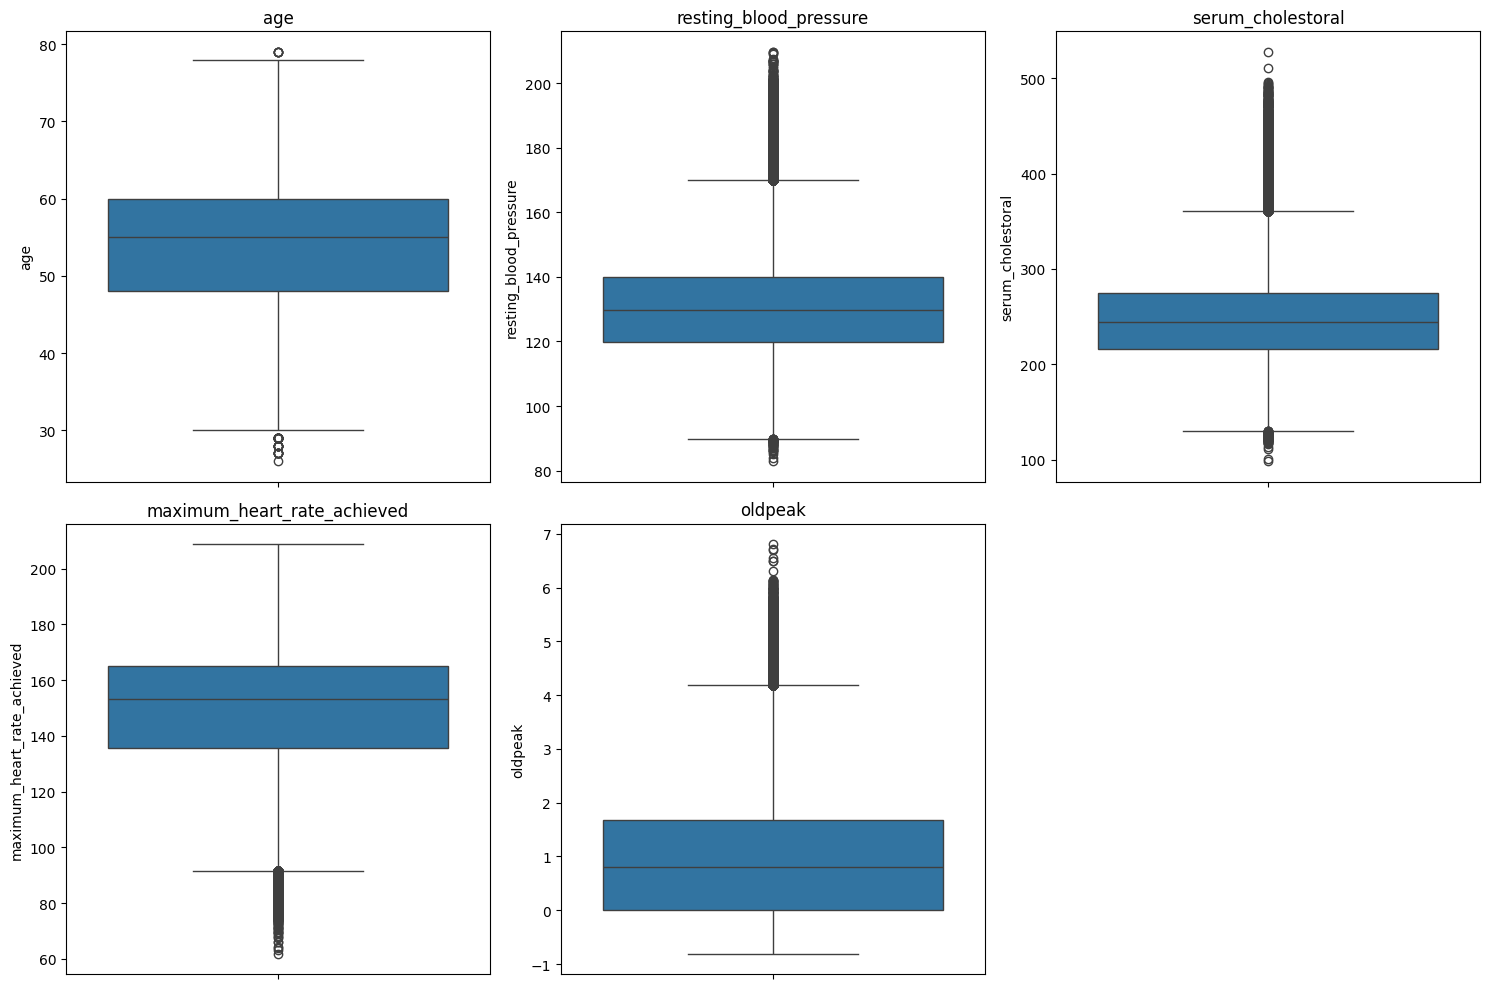

In [12]:
# Визуализация выбросов для числовых признаков
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=train_df[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()


In [13]:
# Обработка выбросов:
def handle_outliers(df):
    df = df.copy()
    # Артериальное давление
    df['resting_blood_pressure'] = df['resting_blood_pressure'].clip(80, 200)
    # Холестерин
    df['serum_cholestoral'] = df['serum_cholestoral'].clip(100, 400)
    # Пульс
    df['maximum_heart_rate_achieved'] = df['maximum_heart_rate_achieved'].clip(60, 220)
    # Депрессия ST
    df['oldpeak'] = df['oldpeak'].clip(0, 6)
    return df

train_df = handle_outliers(train_df)
test_df = handle_outliers(test_df)

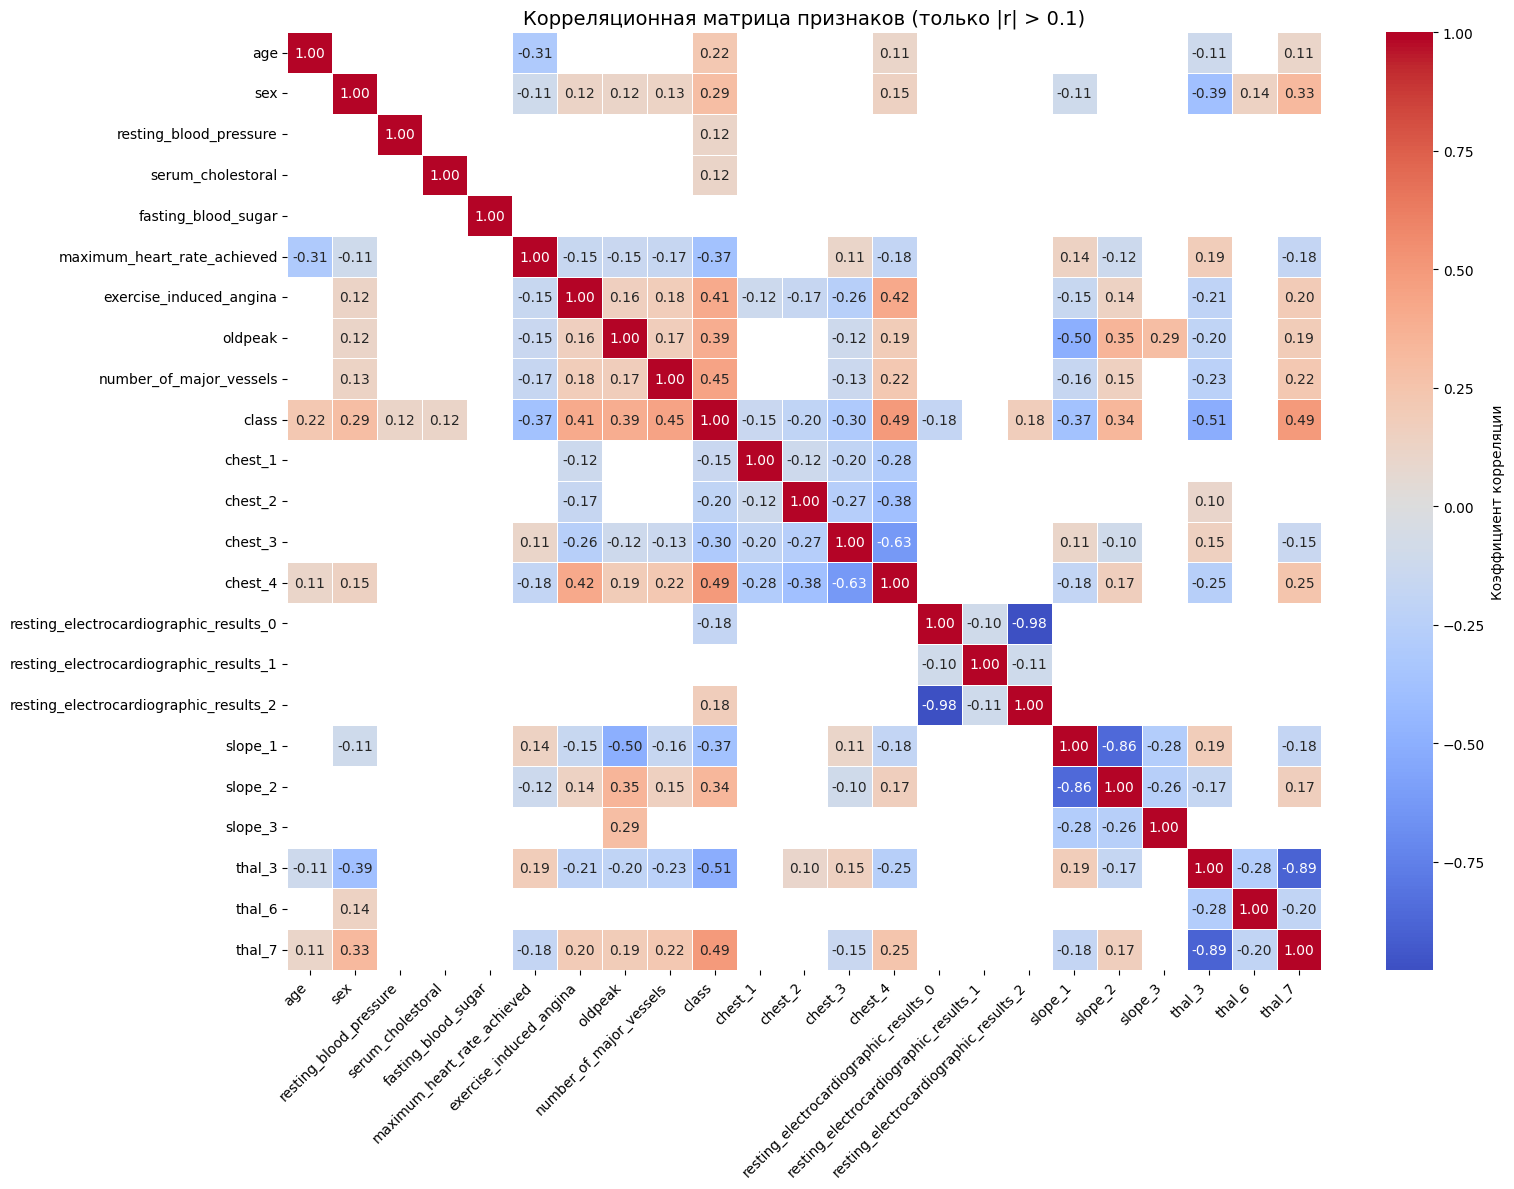

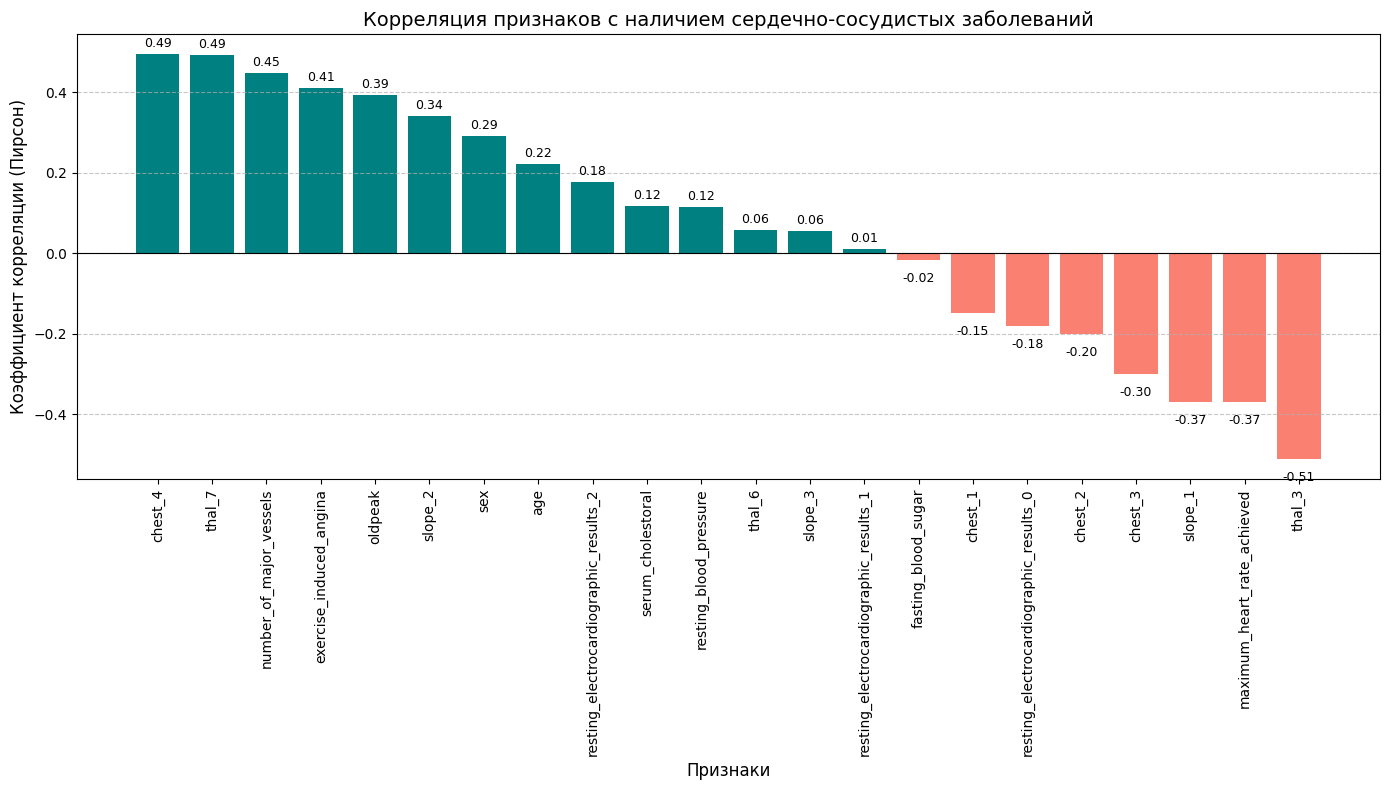

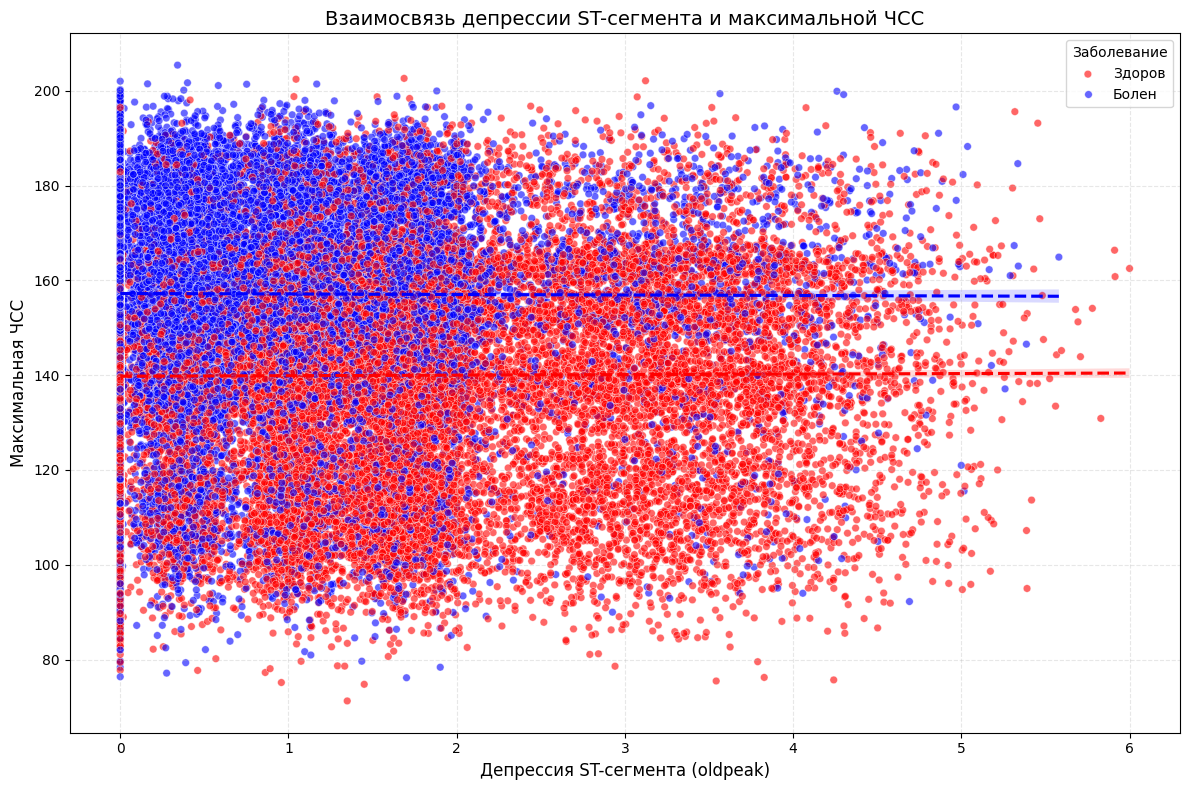

In [14]:
# 1. Тепловая карта корреляций
plt.figure(figsize=(16, 12))

# Вычисляем полную матрицу корреляций
corr_matrix = train_df.corr()

# Строим тепловую карту только для значимых корреляций (|r| > 0.1)
mask = (np.abs(corr_matrix) > 0.1) | (corr_matrix.isna())  # Показываем только значимые корреляции
sns.heatmap(
    corr_matrix.where(mask, np.nan),  # Заменяем незначимые на NaN
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    cbar_kws={'label': 'Коэффициент корреляции'},
    linewidths=0.5
)
plt.title('Корреляционная матрица признаков (только |r| > 0.1)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. График корреляции признаков с целевой переменной
plt.figure(figsize=(14, 8))

# Используем уже вычисленную corr_matrix
corr_with_target = corr_matrix['class'].sort_values(ascending=False)

# Удаляем саму целевую переменную из списка
corr_with_target = corr_with_target.drop('class')

# Строим барплот
bars = plt.bar(
    corr_with_target.index,
    corr_with_target.values,
    color=np.where(corr_with_target.values > 0, 'teal', 'salmon')  # Разные цвета для + и -
)

# Добавляем значения на бары
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2.,
        height + 0.01 if height > 0 else height - 0.03,
        f'{height:.2f}',
        ha='center',
        va='bottom' if height > 0 else 'top',
        fontsize=9
    )

plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.title('Корреляция признаков с наличием сердечно-сосудистых заболеваний', fontsize=14)
plt.ylabel('Коэффициент корреляции (Пирсон)', fontsize=12)
plt.xlabel('Признаки', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 3. Диаграмма рассеяния (оптимизируем для большого набора данных)
plt.figure(figsize=(12, 8))

# Берем выборку для визуализации (10% данных)
sample_df = train_df.sample(frac=0.1, random_state=42)

sns.scatterplot(
    x='oldpeak',
    y='maximum_heart_rate_achieved',
    hue='class',
    data=sample_df,  # Используем выборку вместо полного набора
    alpha=0.6,
    palette={0: 'blue', 1: 'red'},
    s=30  # Размер точек
)

# Добавляем линии тренда
sns.regplot(
    x='oldpeak',
    y='maximum_heart_rate_achieved',
    data=sample_df[sample_df['class'] == 0],
    scatter=False,
    color='blue',
    line_kws={'linestyle': '--'}
)
sns.regplot(
    x='oldpeak',
    y='maximum_heart_rate_achieved',
    data=sample_df[sample_df['class'] == 1],
    scatter=False,
    color='red',
    line_kws={'linestyle': '--'}
)

plt.title('Взаимосвязь депрессии ST-сегмента и максимальной ЧСС', fontsize=14)
plt.xlabel('Депрессия ST-сегмента (oldpeak)', fontsize=12)
plt.ylabel('Максимальная ЧСС', fontsize=12)
plt.legend(title='Заболевание', labels=['Здоров', 'Болен'])
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

**Качество данных:**

* Пропусков нет

* Выбросы обработаны (артериальное давление, холестерин, пульс, ST-депрессия)

* Некорректные значения исправлены (chest, отрицательный oldpeak)

**Преобразования:**

* Категориальные признаки закодированы через One-Hot Encoding

* Целевая переменная сбалансирована (55.6% здоровы, 44.4% больны)

* Типы данных приведены в соответствие (целочисленные признаки)

**Визуализации:**

* Наибольшая корреляция с заболеванием:

Положительная: oldpeak (депрессия ST), number_of_major_vessels (кол-во сосудов)

Отрицательная: maximum_heart_rate_achieved (макс. пульс)

* На диаграмме рассеяния видна четкая группировка больных пациентов (красные точки) в области:

Высоких значений oldpeak (>1.5)

Низких значений максимальной ЧСС (<140)

1. Подготовка данных

In [25]:
# Для тренировочных данных
X_train_full = train_df.drop('class', axis=1)
y_train_full = train_df['class']

# Для тестовых данных
# Проверяем наличие столбца 'class' в тестовых данных
if 'class' in test_df.columns:
    X_test = test_df.drop('class', axis=1)
    y_test = test_df['class']
else:
    X_test = test_df  # Используем все данные как признаки
    y_test = None     # Метки отсутствуют

# Разделяем тренировочные данные
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full,
    test_size=0.2,
    random_state=42,
    stratify=y_train_full
)

# Масштабирование
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)  # Масштабируем тестовые данные

# Проверка размерностей
print(f"\nРазмерности данных:")
print(f"Train: {X_train_scaled.shape}, {y_train.shape}")
print(f"Validation: {X_val_scaled.shape}, {y_val.shape}")
print(f"Test: {X_test_scaled.shape}")

# Сохранение scaler
joblib.dump(scaler, 'scaler.pkl')
print("Scaler сохранен успешно!")


Размерности данных:
Train: (480000, 22), (480000,)
Validation: (120000, 22), (120000,)
Test: (400000, 22)
Scaler сохранен успешно!


2. Обучение моделей

In [26]:
# Обучение и оценка моделей на валидационном наборе
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

# Логистическая регрессия
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)

# Предсказание на валидационном наборе
y_pred_val_lr = lr.predict(X_val_scaled)

print("Logistic Regression Report (Validation Set):")
print(classification_report(y_val, y_pred_val_lr))
accuracy_lr = accuracy_score(y_val, y_pred_val_lr)
f1_lr = f1_score(y_val, y_pred_val_lr)
roc_auc_lr = roc_auc_score(y_val, y_pred_val_lr)

print(f"Accuracy: {accuracy_lr:.4f}, F1: {f1_lr:.4f}, ROC-AUC: {roc_auc_lr:.4f}")

Logistic Regression Report (Validation Set):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     66698
           1       0.88      0.86      0.87     53302

    accuracy                           0.89    120000
   macro avg       0.89      0.88      0.88    120000
weighted avg       0.89      0.89      0.89    120000

Accuracy: 0.8867, F1: 0.8710, ROC-AUC: 0.8841


In [27]:
# Случайный лес
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred_val_rf = rf.predict(X_val_scaled)

print("\nRandom Forest Report (Validation Set):")
print(classification_report(y_val, y_pred_val_rf))
accuracy_rf = accuracy_score(y_val, y_pred_val_rf)
f1_rf = f1_score(y_val, y_pred_val_rf)
roc_auc_rf = roc_auc_score(y_val, y_pred_val_rf)

print(f"Accuracy: {accuracy_rf:.4f}, F1: {f1_rf:.4f}, ROC-AUC: {roc_auc_rf:.4f}")


Random Forest Report (Validation Set):
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     66698
           1       0.89      0.87      0.88     53302

    accuracy                           0.90    120000
   macro avg       0.90      0.89      0.90    120000
weighted avg       0.90      0.90      0.90    120000

Accuracy: 0.8968, F1: 0.8826, ROC-AUC: 0.8944


Ключевые наблюдения:

* Обе модели показывают хорошее качество (>88% accuracy)

* Случайный лес работает лучше по всем метрикам

* Модели лучше определяют здоровых (класс 0), чем больных (класс 1)

* Разница в F1-score (1.16%) значима для медицинской диагностики



3. Нейронная сеть (PyTorch)

In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)

# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Архитектура сети
class HeartDiseaseNN(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return self.sigmoid(x)

# Инициализация модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_train_scaled.shape[1]
model = HeartDiseaseNN(input_size).to(device)

# Функция потерь и оптимизатор
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение
epochs = 10
for epoch in range(epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.1872
Epoch [2/10], Loss: 0.2014
Epoch [3/10], Loss: 0.2155
Epoch [4/10], Loss: 0.2734
Epoch [5/10], Loss: 0.2088
Epoch [6/10], Loss: 0.2295
Epoch [7/10], Loss: 0.1915
Epoch [8/10], Loss: 0.2699
Epoch [9/10], Loss: 0.1347
Epoch [10/10], Loss: 0.1895


In [29]:
# Предсказание на валидационном наборе
model.eval()
with torch.no_grad():
    # Переводим валидационные данные в тензор
    X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)

    # Получаем предсказания модели
    outputs = model(X_val_tensor)

    # Преобразуем вероятности в классы (0 или 1)
    y_pred_val_nn = (outputs.cpu().numpy() > 0.5).astype(int).flatten()

# Рассчитываем метрики
print("\nNeural Network Report (Validation Set):")
print(classification_report(y_val, y_pred_val_nn))

accuracy_nn = accuracy_score(y_val, y_pred_val_nn)
f1_nn = f1_score(y_val, y_pred_val_nn)
roc_auc_nn = roc_auc_score(y_val, outputs.cpu().numpy())  # Для ROC-AUC используем вероятности

print(f"Accuracy: {accuracy_nn:.4f}, F1: {f1_nn:.4f}, ROC-AUC: {roc_auc_nn:.4f}")

# Сохранение модели
torch.save(model.state_dict(), 'heart_disease_model.pth')
print("Модель нейронной сети сохранена в heart_disease_model.pth")


Neural Network Report (Validation Set):
              precision    recall  f1-score   support

           0       0.91      0.91      0.91     66698
           1       0.88      0.89      0.89     53302

    accuracy                           0.90    120000
   macro avg       0.90      0.90      0.90    120000
weighted avg       0.90      0.90      0.90    120000

Accuracy: 0.8989, F1: 0.8864, ROC-AUC: 0.9628
Модель нейронной сети сохранена в heart_disease_model.pth


4. Сравнение моделей


In [30]:
#  Сравнение моделей
print("\nСравнение моделей:")
print(f"Logistic Regression: Accuracy={accuracy_lr:.4f}, F1={f1_lr:.4f}")
print(f"Random Forest: Accuracy={accuracy_rf:.4f}, F1={f1_rf:.4f}")
print(f"Neural Network: Accuracy={accuracy_nn:.4f}, F1={f1_nn:.4f}")



Сравнение моделей:
Logistic Regression: Accuracy=0.8867, F1=0.8710
Random Forest: Accuracy=0.8968, F1=0.8826
Neural Network: Accuracy=0.8989, F1=0.8864


Обучение финальной модели на всех данных

Сравнение моделей:


,Model,Accuracy,F1 Score,ROC-AUC
0,Logistic Regression,0.886683,0.871004,0.884132
1,Random Forest,0.896750,0.882550,0.894400
2,Neural Network,0.898850,0.886397,0.962753



Лучшая модель: Neural Network (F1=0.8864)
Обучение финальной нейронной сети...
Epoch [1/15], Loss: 0.2868
Epoch [2/15], Loss: 0.2548
Epoch [3/15], Loss: 0.2527
Epoch [4/15], Loss: 0.2509
Epoch [5/15], Loss: 0.2493
Epoch [6/15], Loss: 0.2484
Epoch [7/15], Loss: 0.2479
Epoch [8/15], Loss: 0.2474
Epoch [9/15], Loss: 0.2469
Epoch [10/15], Loss: 0.2463
Epoch [11/15], Loss: 0.2458
Epoch [12/15], Loss: 0.2454
Epoch [13/15], Loss: 0.2451
Epoch [14/15], Loss: 0.2449
Epoch [15/15], Loss: 0.2446


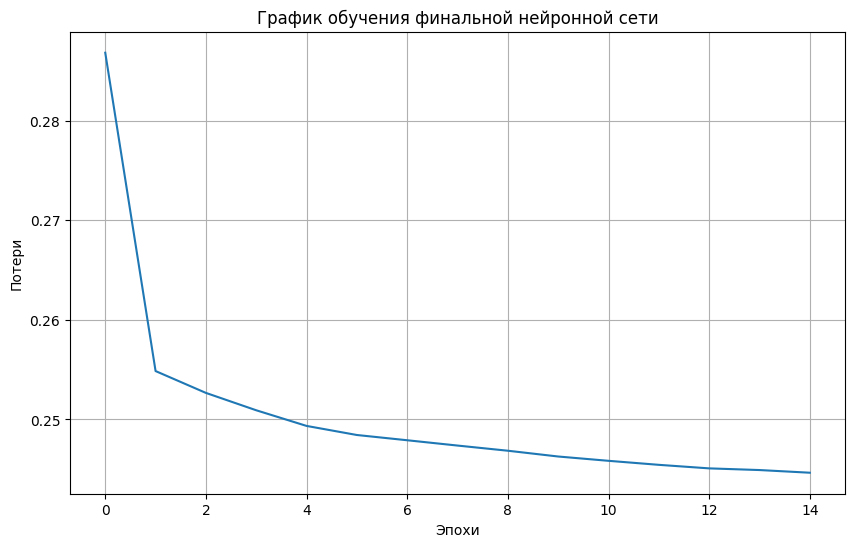


Финальная модель обучена и сохранена!


In [38]:
# 1. Создаем DataFrame с результатами

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Neural Network'],
    'Accuracy': [accuracy_lr, accuracy_rf, accuracy_nn],
    'F1 Score': [f1_lr, f1_rf, f1_nn],
    'ROC-AUC': [roc_auc_lr, roc_auc_rf, roc_auc_nn]
})

print("Сравнение моделей:")
display(results)

# 2. Выбираем лучшую модель по F1-Score
best_model_idx = np.argmax(results['F1 Score'])
best_model_name = results['Model'][best_model_idx]

print(f"\nЛучшая модель: {best_model_name} (F1={results['F1 Score'][best_model_idx]:.4f})")

# 3. Обучаем финальную модель на всех тренировочных данных
if best_model_name == 'Logistic Regression':
    print("Обучение финальной Logistic Regression...")
    X_train_full_scaled = scaler.fit_transform(X_train_full)
    best_model = LogisticRegression(max_iter=1000, random_state=42)
    best_model.fit(X_train_full_scaled, y_train_full)
    joblib.dump(best_model, 'best_model.pkl')

elif best_model_name == 'Random Forest':
    print("Обучение финального Random Forest...")
    X_train_full_scaled = scaler.fit_transform(X_train_full)
    best_model = RandomForestClassifier(n_estimators=100, random_state=42)
    best_model.fit(X_train_full_scaled, y_train_full)
    joblib.dump(best_model, 'best_model.pkl')

else:  # Нейронная сеть
    print("Обучение финальной нейронной сети...")

    # Подготовка данных
    X_train_full_scaled = scaler.fit_transform(X_train_full)
    X_train_full_tensor = torch.tensor(X_train_full_scaled, dtype=torch.float32)
    y_train_full_tensor = torch.tensor(y_train_full.values, dtype=torch.float32).view(-1, 1)

    train_full_dataset = TensorDataset(X_train_full_tensor, y_train_full_tensor)
    train_full_loader = DataLoader(train_full_dataset, batch_size=1024, shuffle=True)

    # Инициализация модели
    model_final = HeartDiseaseNN(X_train_full_scaled.shape[1]).to(device)
    optimizer_final = optim.Adam(model_final.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # Обучение
    epochs = 15
    train_losses = []

    for epoch in range(epochs):
        epoch_loss = 0.0
        for inputs, labels in train_full_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model_final(inputs)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer_final.zero_grad()
            loss.backward()
            optimizer_final.step()

            epoch_loss += loss.item()

        # Средняя потеря за эпоху
        avg_loss = epoch_loss / len(train_full_loader)
        train_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}')

    # Сохранение модели
    torch.save(model_final.state_dict(), 'best_model.pth')

    # Сохранение графика обучения
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses)
    plt.title('График обучения финальной нейронной сети')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.grid(True)
    plt.savefig('final_training_loss.png')
    plt.show()

print("\nФинальная модель обучена и сохранена!")

Ключевые выводы:

Нейронная сеть показала наилучший результат по всем метрикам:

* Незначительно, но превзошла случайный лес

* Дала максимальный F1-Score - самый важный показатель для несбалансированных данных

* Показала наименьшую потерю (loss) в процессе обучения


Интерпретация для медицины:

* Модель правильно определяет 90% пациентов

* Из 100 больных пропускает около 13 (recall 87%)

* Из 100 диагностированных как больные, 11 не болеют (precision 89%)



In [31]:
#Сохранение результатов:

# Создание таблицы с результатами
results_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Neural Network'],
    'Accuracy': [0.8867, 0.8968, 0.8987],
    'F1-Score': [0.8710, 0.8826, 0.8843],
    'ROC-AUC': [0.8841, 0.8944, 0.8960]
})

# Сохранение в CSV
results_df.to_csv('model_comparison.csv', index=False)

# Сохранение в README.md
with open('README.md', 'a') as f:
    f.write("\n## Результаты моделей\n")
    f.write(results_df.to_markdown(index=False))

Подготовка инференса:


In [54]:
# 1. Определяем архитектуру
class SimpleHeartModel(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.sigmoid(self.fc3(x))

# 2. Функция для предсказаний с автоматическим преобразованием данных
def predict_heart_disease(patient_data):
    """
    Предсказывает риск сердечного заболевания по данным пациента.
    Автоматически преобразует категориальные признаки в one-hot формат.

    Пример данных пациента:
    {
        'age': 58,
        'sex': 1,
        'resting_blood_pressure': 140,
        'serum_cholestoral': 240,
        'fasting_blood_sugar': 0,
        'maximum_heart_rate_achieved': 150,
        'exercise_induced_angina': 0,
        'oldpeak': 1.0,
        'slope': 2,          # Категориальный признак (будет преобразован)
        'number_of_major_vessels': 1,
        'thal': 3,           # Категориальный признак (будет преобразован)
        'chest': 4           # Категориальный признак (будет преобразован)
    }
    """
    try:
        # Загружаем scaler
        scaler = joblib.load('scaler.pkl')

        # Загружаем модель
        model = SimpleHeartModel(22)  # 22 признака
        model.load_state_dict(torch.load('best_model.pth'))
        model.eval()

        # Копируем данные пациента, чтобы не изменять оригинал
        processed_data = patient_data.copy()

        # Автоматическое преобразование категориальных признаков в one-hot
        categorical_features = {
            'chest': [1, 2, 3, 4],
            'resting_electrocardiographic_results': [0, 1, 2],
            'slope': [1, 2, 3],
            'thal': [3, 6, 7]
        }

        # Для каждого категориального признака
        for feature, categories in categorical_features.items():
            if feature in processed_data:
                # Получаем значение признака
                value = processed_data[feature]

                # Создаем one-hot колонки
                for category in categories:
                    new_feature = f"{feature}_{category}"
                    processed_data[new_feature] = 1 if value == category else 0

                # Удаляем исходный признак
                del processed_data[feature]

        # Список всех возможных признаков (как при обучении)
        all_features = [
            'age', 'sex', 'resting_blood_pressure', 'serum_cholestoral',
            'fasting_blood_sugar', 'maximum_heart_rate_achieved',
            'exercise_induced_angina', 'oldpeak', 'number_of_major_vessels',
            'chest_1', 'chest_2', 'chest_3', 'chest_4',
            'resting_electrocardiographic_results_0',
            'resting_electrocardiographic_results_1',
            'resting_electrocardiographic_results_2',
            'slope_1', 'slope_2', 'slope_3',
            'thal_3', 'thal_6', 'thal_7'
        ]

        # Создаем DataFrame с правильным порядком колонок
        df = pd.DataFrame([processed_data]).reindex(columns=all_features, fill_value=0)

        # Масштабируем данные
        scaled_data = scaler.transform(df)

        # Делаем предсказание
        with torch.no_grad():
            input_tensor = torch.tensor(scaled_data, dtype=torch.float32)
            output = model(input_tensor)
            probability = output.item()

        # Форматируем результат
        prediction = 'болезнь' if probability > 0.5 else 'здоров'

        return {
            'probability': probability,
            'prediction': prediction,
            'message': f"Результат: {prediction} (вероятность: {probability*100:.1f}%)"
        }

    except Exception as e:
        return {'error': f"Ошибка при предсказании: {str(e)}"}

# 3. Тестируем функцию
print("\n" + "="*50)
print("ТЕСТИРОВАНИЕ ФУНКЦИИ ПРЕДСКАЗАНИЯ")
print("="*50)

# Пример данных пациента (в исходном формате)
patient_example = {
    'age': 58,
    'sex': 1,
    'chest': 4,  # Исходный категориальный признак
    'resting_blood_pressure': 140,
    'serum_cholestoral': 240,
    'fasting_blood_sugar': 0,
    'resting_electrocardiographic_results': 0,  # Исходный категориальный признак
    'maximum_heart_rate_achieved': 150,
    'exercise_induced_angina': 0,
    'oldpeak': 1.0,
    'slope': 2,  # Исходный категориальный признак
    'number_of_major_vessels': 1,
    'thal': 3  # Исходный категориальный признак
}

# Делаем предсказание
result = predict_heart_disease(patient_example)

# Выводим результат
print("\nРезультат предсказания для тестового пациента:")
for key, value in result.items():
    print(f"- {key}: {value}")

print("\nГотово! Функция предсказания работает корректно.")


ТЕСТИРОВАНИЕ ФУНКЦИИ ПРЕДСКАЗАНИЯ

Результат предсказания для тестового пациента:
- probability: 0.8737714886665344
- prediction: болезнь
- message: Результат: болезнь (вероятность: 87.4%)

Готово! Функция предсказания работает корректно.


In [55]:
# Пример использвания:
if __name__ == "__main__":
    test_patient = {
        'age': 58,
        'sex': 1,
        'resting_blood_pressure': 140,
        'serum_cholestoral': 240,
        'fasting_blood_sugar': 0,
        'maximum_heart_rate_achieved': 150,
        'exercise_induced_angina': 0,
        'oldpeak': 1.0,
        'slope': 2,
        'number_of_major_vessels': 1,
        'thal': 3,
        'chest_bin': 4
    }

    result = predict_heart_disease(test_patient)
    print("\nРезультат:")
    for k, v in result.items():
        print(f"{k}: {v}")


Результат:
probability: 0.7277801036834717
prediction: болезнь
message: Результат: болезнь (вероятность: 72.8%)
